In [2]:
from datasets import load_dataset, Dataset, concatenate_datasets
from tqdm import tqdm

/Users/leandro/git/sandbox/env/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
from huggingface_hub import HfApi

api = HfApi()

## DeepMind Mathematics

In [ ]:
!ls ./data/mathematics_dataset-v1.0/

In [ ]:
train_folders = ["train-easy", "train-medium", "train-hard"]

In [ ]:
data_folder = "./data/mathematics_dataset-v1.0"
ds = []

for folder in train_folders:
    samples = []
    difficulty = folder.split("-")[1]
    files = !ls {data_folder}/{folder}
    for file in tqdm(files):
        field, topic = file.split(".")[0].split("__")
        with open(f"{data_folder}/{folder}/{file}") as f:
            data = f.read().split("\n")
            assert len(data)%2!=0
            for i in range(int(len(data)/2)):
                sample = {
                    "content": "\n".join(data[2*i:2*(i+1)]),
                    "metadata": {
                        "difficulty": difficulty,
                        "field": field,
                        "topic": topic,
                                }
                }
                samples.append(sample)
    ds.append(Dataset.from_list(samples))

In [ ]:
ds_all = concatenate_datasets(ds)

In [ ]:
ds_all

In [ ]:
ds_all[10]

In [ ]:
ds_all.to_parquet(data_folder+"/00000-data.parquet")

In [ ]:
api.upload_file(
    path_or_fileobj=data_folder+"/00000-data.parquet",
    path_in_repo="data/deepmind_mathematics_dataset/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add DeepMind Math dataset",
)

## GSM8K

In [ ]:
!ls ./data/gsm8k-screl/

In [ ]:
import json

data = []

with open("./data/gsm8k-screl/u33b.jsonl", "r") as f:
    for line in f.readlines():
        data_sample = json.loads(line)
        data.append({"content": data_sample["query"] + "\n" + data_sample["response"]})

In [ ]:
ds = Dataset.from_list(data)

In [ ]:
ds

In [ ]:
ds.to_parquet("./data/gsm8k-scirel-u33.parquet")

In [ ]:
api.upload_file(
    path_or_fileobj="./data/gsm8k-scirel-u33.parquet",
    path_in_repo="data/gsm8k-scirel-u33/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add GSM8K SciRel dataset",
)

In [ ]:
ds_gsm8k = load_dataset("gsm8k","main", split="train")

In [ ]:
ds_gsm8k

In [ ]:
ds_gsm8k[0]
ds_gsm8k = ds_gsm8k.map(lambda x: {"content": x["question"] + "\n" + x["answer"]})

In [ ]:
ds_gsm8k[0]

In [ ]:
ds_gsm8k = ds_gsm8k.remove_columns(["question", "answer"])

In [ ]:
ds_gsm8k.to_parquet("./data/gsm8k-train.parquet")

In [ ]:
api.upload_file(
    path_or_fileobj="./data/gsm8k-train.parquet",
    path_in_repo="data/gsm8k-train/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add GSM8K train dataset",
)

## APPS

In [ ]:
ds_apps = load_dataset("codeparrot/apps", split="train")

In [ ]:
# from bigcode-evaluation-harness

def get_prompt(doc):
        """Generate prompts for APPS
        Finetuning setup: prompt=question  with some starter code and function name if they exist.
        We also specify the type of the prompt, i.e. whether it is call-based or standard input-based.
        """
        starter_code = None if len(doc["starter_code"]) == 0 else doc["starter_code"]
        try:
            input_outpout = json.loads(doc["input_output"])
            fn_name = (
                None if not input_outpout.get("fn_name") else input_outpout["fn_name"]
            )
        except ValueError:
            fn_name = None
        prompt = "\nQUESTION:\n"
        prompt += doc["question"]
        if starter_code:
            prompt += starter_code
        if not fn_name:
            call_format = "\nUse Standard Input format"
            prompt += call_format
        else:
            call_format = "\nUse Call-Based format"
            prompt += call_format
        prompt += "\nANSWER:\n"
        prompt += json.loads(doc["solutions"])[0]
        return {"content": prompt}

In [ ]:
ds_apps = ds_apps.map(get_prompt)

In [ ]:
print(ds_apps[0]["content"])

In [ ]:
ds_apps

In [ ]:
ds_apps = ds_apps.remove_columns(['problem_id', 'question', 'solutions', 'input_output', 'difficulty', 'url', 'starter_code',])

In [ ]:
ds_apps

In [ ]:
ds_apps.to_parquet("./data/apps-train.parquet")

In [ ]:
ds_apps.to_parquet("./data/apps-train.parquet")

api.upload_file(
    path_or_fileobj="./data/apps-train.parquet",
    path_in_repo="data/apps-train/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add APPS train dataset",
)

## Code Contest

In [ ]:
ds_cc = load_dataset("deepmind/code_contests", split="train")

In [ ]:
ds_cc

In [ ]:
print(ds_cc[1]["name"])
print()
print(ds_cc[1]["description"])
print()
print(ds_cc[1]["solutions"]["solution"][0])

In [ ]:
from collections import Counter

id2lang = {
    0: "uknown",
    1: "Python 2",
    2: "CPP",
    3: "Python 3",
    4: "Java"
}

counter = Counter()

for i in range(1000):
    counter.update([id2lang[lang] for lang in ds_cc[i]["solutions"]["language"]])
print(counter)

In [ ]:
def deduplicate_solutions(doc):
    langs = []
    solutions = []
    
    for solution, lang in zip(doc["solutions"]["solution"], doc["solutions"]["language"]):
        if id2lang[lang] not in langs:
            langs.append(id2lang[lang])
            solutions.append(solution)
            
    return {"clean_solutions": solutions, "clean_langs": langs}

In [ ]:
ds_cc = ds_cc.map(deduplicate_solutions)

In [ ]:
def setup_content(doc):
    content = doc["description"]
    content += "\n"
    for lang, sol in zip(doc["clean_langs"], doc["clean_solutions"]):
        content += f"Solution ({lang}):"
        content += sol
        content += "\n"
    return {"content": content.strip()}

In [ ]:
ds_cc = ds_cc.map(setup_content)

In [ ]:
ds_cc = ds_cc.remove_columns(['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_index', 'cf_points', 'cf_rating', 'cf_tags', 'is_description_translated', 'untranslated_description', 'time_limit', 'memory_limit_bytes', 'input_file', 'output_file', 'clean_solutions', 'clean_langs'])

In [ ]:
ds_cc.to_parquet("./data/code-contest.parquet")

api.upload_file(
    path_or_fileobj="./data/code-contest.parquet",
    path_in_repo="data/code-contest-train/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add Code Contest train dataset",
)

## Rosetta

In [3]:
dataset = load_dataset("cakiki/rosetta-code", split="train")

Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/cakiki___parquet/cakiki--rosetta-code-c68b129ca95ba990/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


In [4]:
dataset

Dataset({
    features: ['task_url', 'task_name', 'task_description', 'language_url', 'language_name', 'code'],
    num_rows: 79013
})

In [5]:
dataset[0]

{'task_url': 'http://rosettacode.org/wiki/Ascending_primes',
 'task_name': 'Ascending primes',
 'task_description': "Generate and show all primes with strictly ascending decimal digits.\n\nAside: Try solving without peeking at existing solutions. I had a weird idea for generating\na prime sieve faster, which needless to say didn't pan out. The solution may be p(r)etty trivial\nbut generating them quickly is at least mildly interesting.\nTip: filtering all 7,027,260 primes below 123,456,789 probably won't kill you, but there is\nat least one significantly better and much faster way, needing a mere 511 odd/prime tests.\n\n\n\nSee also\n OEIS:A052015 - Primes with distinct digits in ascending order\n\n\nRelated\n\nPrimes with digits in nondecreasing order (infinite series allowing duplicate digits, whereas this isn't and doesn't)\nPandigital prime (whereas this is the smallest, with gaps in the used digits being permitted)\n\n",
 'language_url': '#ALGOL_68',
 'language_name': 'ALGOL 68',


In [6]:
print(dataset[4]["language_name"])
print(dataset[4]["code"])

Factor
USING: grouping math math.combinatorics math.functions
math.primes math.ranges prettyprint sequences sequences.extras ;
 
9 [1,b] all-subsets [ reverse 0 [ 10^ * + ] reduce-index ]
[ prime? ] map-filter 10 group simple-table.


In [7]:
from collections import defaultdict
problems = defaultdict(list)

for element in dataset:
    problems[element["task_name"] + "\n" + element["task_description"]].append(f'Language: {element["language_name"]}\n{element["code"]}')

In [11]:
contents = []

for problem in problems:
    contents.append({"content": problem + "\n\n" + "\n\n".join(problems[problem])})

In [13]:
ds_rosetta = Dataset.from_list(contents)

In [14]:
ds_rosetta

Dataset({
    features: ['content'],
    num_rows: 1182
})

In [15]:
ds_rosetta.to_parquet("./data/rosetta-code.parquet")

api.upload_file(
    path_or_fileobj="./data/rosetta-code.parquet",
    path_in_repo="data/rosetta-code/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add Rosetta code train dataset",
)

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

rosetta-code.parquet:   0%|          | 0.00/34.9M [00:00<?, ?B/s]

'https://huggingface.co/datasets/bigcode/starcoder2-special/blob/main/data/rosetta-code/00000-data.parquet'

## MultiPL-T

In [3]:
ds = load_dataset("nuprl/MultiPL-T")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating lua split:   0%|          | 0/48194 [00:00<?, ? examples/s]

Generating ocaml split:   0%|          | 0/43401 [00:00<?, ? examples/s]

Generating racket split:   0%|          | 0/40510 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/leandro/.cache/huggingface/datasets/nuprl___parquet/nuprl--MultiPL-T-29ccda1515a43057/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ds

DatasetDict({
    lua: Dataset({
        features: ['content'],
        num_rows: 48194
    })
    ocaml: Dataset({
        features: ['content'],
        num_rows: 43401
    })
    racket: Dataset({
        features: ['content'],
        num_rows: 40510
    })
})

In [5]:
ds_lua = load_dataset("nuprl/stack_dedup_lua_codegen_full")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/117557 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/leandro/.cache/huggingface/datasets/nuprl___parquet/nuprl--stack_dedup_lua_codegen_full-6e8804842d127749/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
ds_lua

DatasetDict({
    train: Dataset({
        features: ['content', 'pass_rate', 'id', 'original_id', 'tests', 'edu_score'],
        num_rows: 117557
    })
})

In [7]:
ds_lua = ds_lua.remove_columns(['pass_rate', 'id', 'original_id', 'tests', 'edu_score'])

In [9]:
ds_multiplt = concatenate_datasets([ds_lua["train"], ds["racket"], ds["ocaml"]])

In [10]:
ds_multiplt

Dataset({
    features: ['content'],
    num_rows: 201468
})

In [15]:
ds_multiplt.to_parquet("./data/multipl-t.parquet")

Creating parquet from Arrow format:   0%|          | 0/202 [00:00<?, ?ba/s]

97045960

In [11]:
api.upload_file(
    path_or_fileobj="./data/multipl-t.parquet",
    path_in_repo="data/multipl-t/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add MultiPL-T code train dataset",
)

Creating parquet from Arrow format:   0%|          | 0/202 [00:00<?, ?ba/s]

mutlipl-t.parquet:   0%|          | 0.00/47.1M [00:00<?, ?B/s]

'https://huggingface.co/datasets/bigcode/starcoder2-special/blob/main/data/multipl-t/00000-data.parquet'

## Open Web Math

In [ ]:
dataset = load_dataset("open-web-math/open-web-math")

## Proof Pile

In [22]:
ds_isa = load_dataset("xu3kev/proof-pile-2-proofsteps", data_dir="isa_proofsteps", split="train")
ds_lean = load_dataset("xu3kev/proof-pile-2-proofsteps", data_dir="lean_proofsteps", split="train")

Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/xu3kev___parquet/xu3kev--proof-pile-2-proofsteps-931653b4c1f36c10/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/xu3kev___parquet/xu3kev--proof-pile-2-proofsteps-bc4a881afa526220/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


In [25]:
ds_isa = ds_isa.rename_columns({"text": "content"})
ds_lean = ds_lean.rename_columns({"text": "content"})

In [27]:
ds_lean

Dataset({
    features: ['content', 'meta'],
    num_rows: 3396
})

In [28]:
ds_isa.to_parquet("./data/proofsteps-isa.parquet")
ds_lean.to_parquet("./data/proofsteps-lean.parquet")

Creating parquet from Arrow format:   0%|          | 0/259 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

162783824

In [29]:
api.upload_file(
    path_or_fileobj="./data/proofsteps-isa.parquet",
    path_in_repo="data/proofsteps-isa/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add proofsteps-isa train dataset",
)

proofsteps-isa.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

'https://huggingface.co/datasets/bigcode/starcoder2-special/blob/main/data/proofsteps-isa/00000-data.parquet'

In [30]:
api.upload_file(
    path_or_fileobj="./data/proofsteps-lean.parquet",
    path_in_repo="data/proofsteps-lean/00000-data.parquet",
    repo_id="bigcode/starcoder2-special",
    repo_type="dataset",
    commit_message=f"Add proofsteps-lean train dataset",
)

proofsteps-lean.parquet:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

'https://huggingface.co/datasets/bigcode/starcoder2-special/blob/main/data/proofsteps-lean/00000-data.parquet'

## Statistics

In [34]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder")

data_sources = [
    "apps-train",
    "code-contest",
    #"deepmind_mathematics_dataset",
    "gsm8k-scirel-u33",
    "gsm8k-train",
    "rosetta-code",
    "multipl-t",
    "proofsteps-lean",
    "proofsteps-isa",
]


In [35]:
def tokenize(examples):
    return {"len": [len(x) for x in tokenizer(examples["content"]).input_ids]}

In [36]:
len_dist = {}
for data_source in data_sources:
    ds = load_dataset("./", data_files=[f"data/{data_source}.parquet"], split="train")
    ds = ds.map(tokenize, batched=True, batch_size=1000)
    len_dist[data_source] = ds["len"]

Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/parquet/.-a3a218561bd6db17/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /Users/leandro/.cache/huggingface/datasets/parquet/.-a3a218561bd6db17/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-0a43a555fb253351.arrow
Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/parquet/.-fc5799d4c439dedd/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /Users/leandro/.cache/huggingface/datasets/parquet/.-fc5799d4c439dedd/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-9e5263fbdb5e0cc8.arrow
Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/parquet/.-0ad34cca5b199149/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Map:   0%|          | 0/110142 [00:00<?, ? examples/s]

Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/parquet/.-5bd63274b07c27cc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/parquet/.-f27b28f5b5640030/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Map:   0%|          | 0/1182 [00:00<?, ? examples/s]

Found cached dataset parquet (/Users/leandro/.cache/huggingface/datasets/parquet/.-11e1f8855fbd38e8/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Map:   0%|          | 0/201468 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /Users/leandro/.cache/huggingface/datasets/parquet/.-d4c782cd56180c25/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /Users/leandro/.cache/huggingface/datasets/parquet/.-e8cea112def26ef0/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


Map:   0%|          | 0/258108 [00:00<?, ? examples/s]

In [37]:
import matplotlib.pyplot as plt
import numpy as np

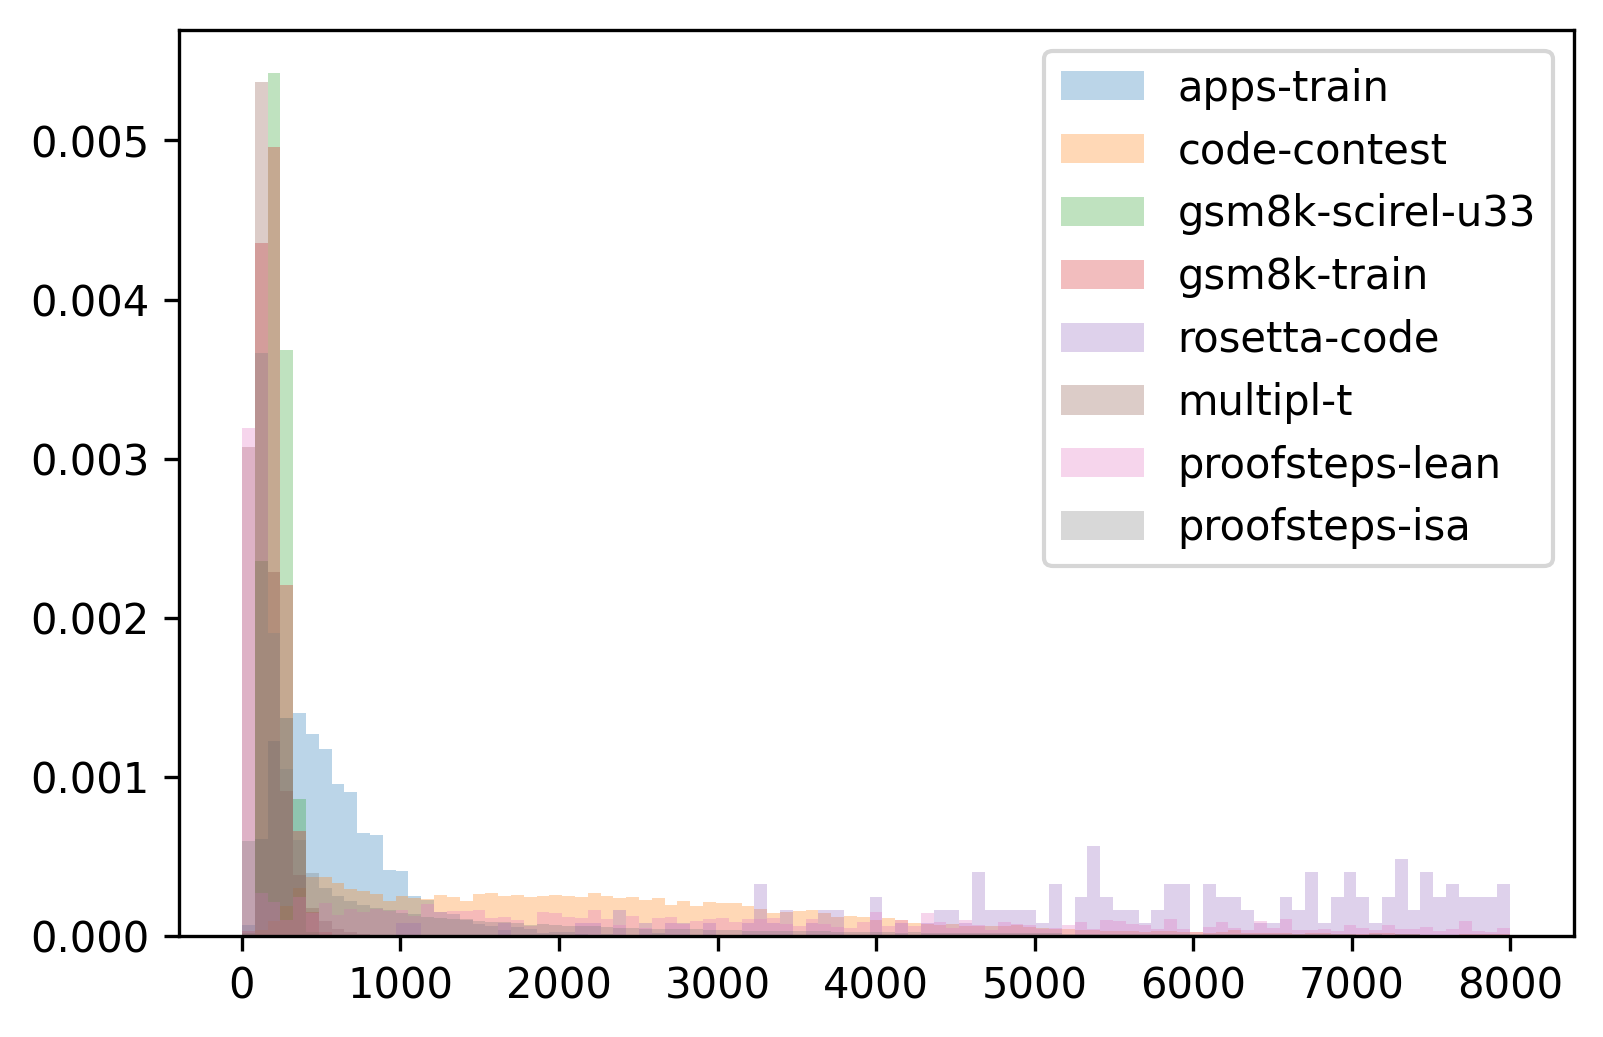

In [46]:
plt.subplots(dpi=300)
bins = np.linspace(0, 8000, 100)
for key in len_dist:
    #if "lean" in key:
    plt.hist(len_dist[key], bins=bins, label=key, alpha=0.3, density=True)
plt.legend(loc="best")
plt.show()

In [40]:
for key in len_dist:
    print(key)
    print("Number of samples: ", len(len_dist[key]))
    print("Total tokens (M):  ", sum(len_dist[key])/1_000_000)
    print("Average tokens:    ", np.mean(len_dist[key]))
    print("="*40)

apps-train
Number of samples:  5000
Total tokens (M):   3.458146
Average tokens:     691.6292
code-contest
Number of samples:  13328
Total tokens (M):   33.777744
Average tokens:     2534.344537815126
gsm8k-scirel-u33
Number of samples:  110142
Total tokens (M):   24.497842
Average tokens:     222.42052986145157
gsm8k-train
Number of samples:  7473
Total tokens (M):   1.493086
Average tokens:     199.79740398768902
rosetta-code
Number of samples:  1182
Total tokens (M):   26.707557
Average tokens:     22595.225888324872
multipl-t
Number of samples:  201468
Total tokens (M):   29.583764
Average tokens:     146.8410070085572
proofsteps-lean
Number of samples:  3396
Total tokens (M):   72.191515
Average tokens:     21257.807714958773
proofsteps-isa
Number of samples:  258108
Total tokens (M):   765.004617
Average tokens:     2963.893474824492


In [41]:
for key in len_dist:
    print(" & ".join([f"{i:.1f}" if not isinstance(i, str) else i for i in [key, len(len_dist[key]), sum(len_dist[key])/1_000_000, np.mean(len_dist[key])]]), "\\\\")

apps-train & 5000.0 & 3.5 & 691.6 \\
code-contest & 13328.0 & 33.8 & 2534.3 \\
gsm8k-scirel-u33 & 110142.0 & 24.5 & 222.4 \\
gsm8k-train & 7473.0 & 1.5 & 199.8 \\
rosetta-code & 1182.0 & 26.7 & 22595.2 \\
multipl-t & 201468.0 & 29.6 & 146.8 \\
proofsteps-lean & 3396.0 & 72.2 & 21257.8 \\
proofsteps-isa & 258108.0 & 765.0 & 2963.9 \\
